# Project: Wrangling and Analyze Data

## Introduction

Data Wrangling is the process of transforming raw data into readily usable formats. It involves gathering, assessing, cleaning, and even merging data to make it usable for analysis. This project wrangles data from ['WeRateDogs'](https://twitter.com/dog_rates?ref_src=twsrc%5Egoogle%7Ctwcamp%5Eserp%7Ctwgr%5Eauthor), a twitter account that rates people's dogs with a humorous comment about the dog. The data required for analysis was scattered across three datasets, as shown in the data gathering phase. The gathered data will be assessed, both visually and programmatically, for quality and tidiness issues. All the assessed issues will be cleaned and the final dataset saved to a csv file for analysis. Afterwards, the wrangled data will be analyzed to generate interesting insights and visualizations on WeRateDogs.

This notebook gives a step-by-step documentation on the wrangling and analysis process.

In [1]:
# import libraries

import pandas as pd
import numpy as np
import requests 
import os
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
import datetime

## Data Gathering

In the cell below, gather all three pieces of data for this project and load them in the notebook. Note: the methods required to gather each data are different.

1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [2]:
df_twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

# check to confirm that the dataset has been successfully downloaded 
df_twitter_archive.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


2. Use the Requests library to download the tweet image prediction (image_predictions.tsv) 

In [3]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

with open ('image-predictions.tsv', mode='wb') as file:
    file.write(response.content)
    
image_pred_df = pd.read_csv('image-predictions.tsv',sep="\t")

# check to confirm that the dataset has been successfully downloaded  
image_pred_df.head(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [4]:
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

In [5]:
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = df_twitter_archive.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

In [6]:
# directly download the tweet_json.txt dataset
tweet_json_df = pd.read_json('tweet-json.txt', lines=True)

# check to confirm that the dataset has been successfully downloaded 
tweet_json_df.head(2)

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,possibly_sensitive_appealable,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,truncated,user
0,NaN,NaN,2017-08-01 16:23:56,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...",39467,False,This is Phineas. He's a mystical boy. Only eve...,NaN,...,0.0,NaN,NaN,NaN,8853,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1,NaN,NaN,2017-08-01 00:17:27,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...",33819,False,This is Tilly. She's just checking pup on you....,NaN,...,0.0,NaN,NaN,NaN,6514,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


In [7]:
# using the pandas function, '.info', confirm the column names of the dataset
tweet_json_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 31 columns):
contributors                     0 non-null float64
coordinates                      0 non-null float64
created_at                       2354 non-null datetime64[ns]
display_text_range               2354 non-null object
entities                         2354 non-null object
extended_entities                2073 non-null object
favorite_count                   2354 non-null int64
favorited                        2354 non-null bool
full_text                        2354 non-null object
geo                              0 non-null float64
id                               2354 non-null int64
id_str                           2354 non-null int64
in_reply_to_screen_name          78 non-null object
in_reply_to_status_id            78 non-null float64
in_reply_to_status_id_str        78 non-null float64
in_reply_to_user_id              78 non-null float64
in_reply_to_user_id_str          78 n

In [8]:
# create a new dataset with the required columns
df_tweet_json = tweet_json_df[['id', 'favorite_count', 'retweet_count']].copy()

# check to see that the new dataset has been successfully created
df_tweet_json.head(2)

,id,favorite_count,retweet_count
0,892420643555336193,39467,8853
1,892177421306343426,33819,6514


## Assessing Data

In this section, detect and document at least eight (8) quality issues and two (2) tidiness issue. You must use both visual assessment programmatic assessement to assess the data.

Note: pay attention to the following key points when you access the data.

- You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
- Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
- The fact that the rating numerators are greater than the denominators does not need to be cleaned. This unique rating system is a big part of the popularity of WeRateDogs.
- You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.

### Visual Assessment of the datasets

In [9]:
# Visual assessment of the twitter archive dataset
df_twitter_archive.head(100)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [10]:
df_twitter_archive.tail(100)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2256,667766675769573376,NaN,NaN,2015-11-20 18:09:16 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",This is Calvin. He is a Luxembourgian Mayo. Ha...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667766675...,9,10,Calvin,None,None,None,None
2257,667728196545200128,NaN,NaN,2015-11-20 15:36:22 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Meet Olive. He comes to spot by tree to remini...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667728196...,11,10,Olive,None,None,None,None
2258,667724302356258817,NaN,NaN,2015-11-20 15:20:54 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",What a dog to start the day with. Very calm. L...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667724302...,7,10,None,None,None,None,None
2259,667550904950915073,NaN,NaN,2015-11-20 03:51:52 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",RT @dogratingrating: Exceptional talent. Origi...,6.675487e+17,4.296832e+09,2015-11-20 03:43:06 +0000,https://twitter.com/dogratingrating/status/667...,12,10,None,None,None,None,None
2260,667550882905632768,NaN,NaN,2015-11-20 03:51:47 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",RT @dogratingrating: Unoriginal idea. Blatant ...,6.675484e+17,4.296832e+09,2015-11-20 03:41:59 +0000,https://twitter.com/dogratingrating/status/667...,5,10,None,None,None,None,None
2261,667549055577362432,NaN,NaN,2015-11-20 03:44:31 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Never seen dog like this. Breathes heavy. Tilt...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667549055...,1,10,None,None,None,None,None
2262,667546741521195010,NaN,NaN,2015-11-20 03:35:20 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Here is George. George took a selfie of his ne...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667546741...,9,10,George,None,None,None,None
2263,667544320556335104,NaN,NaN,2015-11-20 03:25:43 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...","This is Kial. Kial is either wearing a cape, w...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/667544320...,10,10,Kial,None,None,None,None
2264,667538891197542400,NaN,NaN,2015-11-20 03:04:08 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",This is a southwest Coriander named Klint. Hat...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667538891...,9,10,a,None,None,None,None
2265,667534815156183040,NaN,NaN,2015-11-20 02:47:56 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...","This is Frank (pronounced ""Fronq""). Too many b...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/667534815...,8,10,Frank,None,None,None,None


Observed issues from the twitter archive dataset

Quality Issues:

1. Null (NaN) values in the columns 'in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', and 'retweeted_status_timestamp'.
2. Wrong datatypes: the available data in the columns 'retweeted_status_id' and 'retweeted_status_user_id' are floats as shown in rows 19, 73, 74, 78, 91, 95, and 97.
3. Wrong dog names in the column 'name' including: 'such'(row 22), 'a' (rows 2264, 2273, 2327, 2334, 2347, 2348), 'quite' (row 2326), 'an' (rows 2333 and 2335), 'the' (rows 2345 and 2346).
4. The missing values in the columns 'name', 'doggo', 'floofer', 'pupper', and 'puppo' are represented using 'None' instead of 'NaN'.
Tidyness Issues:

1. The 'timestamp' column contain more than one variable. It can be splitted into date and time columns.
2. The columns 'doggo', 'floofer', 'pupper', and 'puppo' represent the single variable dog stages. Therefore, they can be melted or combined to form the column, 'dog_stage'.

In [11]:
# visual assessment of the image prediction dataset
image_pred_df.head(100)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [12]:
image_pred_df.tail(100)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1975,870063196459192321,https://pbs.twimg.com/media/DBMV3NnXUAAm0Pp.jpg,1,comic_book,0.534409,False,envelope,0.280722,False,book_jacket,0.043786,False
1976,870308999962521604,https://pbs.twimg.com/media/DBP1asiUAAEKZI5.jpg,2,Greater_Swiss_Mountain_dog,0.622752,True,Appenzeller,0.158463,True,EntleBucher,0.148115,True
1977,870374049280663552,https://pbs.twimg.com/media/DBQwlFCXkAACSkI.jpg,1,golden_retriever,0.841001,True,Great_Pyrenees,0.099278,True,Labrador_retriever,0.032621,True
1978,870656317836468226,https://pbs.twimg.com/media/DBUxSSTXsAA-Jn1.jpg,4,Pembroke,0.945495,True,Cardigan,0.045875,True,beagle,0.004329,True
1979,870804317367881728,https://pbs.twimg.com/media/DBW35ZsVoAEWZUU.jpg,1,home_theater,0.168290,False,sandbar,0.098040,False,television,0.079729,False
1980,871032628920680449,https://pbs.twimg.com/media/DBaHi3YXgAE6knM.jpg,1,kelpie,0.398053,True,macaque,0.068955,False,dingo,0.050602,False
1981,871515927908634625,https://pbs.twimg.com/media/DBg_HT9WAAEeIMM.jpg,2,komondor,0.974781,True,briard,0.020041,True,swab,0.003228,False
1982,871762521631449091,https://pbs.twimg.com/media/DBkfY58XcAEdzZy.jpg,2,Labrador_retriever,0.921393,True,golden_retriever,0.064608,True,bloodhound,0.003383,True
1983,871879754684805121,https://pbs.twimg.com/media/DBmKAmBXUAE-pQ-.jpg,1,Shetland_sheepdog,0.969171,True,collie,0.018261,True,Pomeranian,0.008515,True
1984,872122724285648897,https://pbs.twimg.com/media/DBpm-5UXcAUeCru.jpg,1,basketball,0.808396,False,pug,0.066736,True,dalmatian,0.054570,True


Observed Issues from the image prediction dataset

1. Columns p1, p1_conf, p1_dog, p2, p2_conf, p2_dog, p3, p3_conf, p3_dog seem to refer to the same thing. They attempt to predict the dog breed from the image url. Therefore, the predictions with the highest confidence values can be used to create one column for dog_breed.
2. Inconsistent dog breed names in columns p1, p2 and p3.

In [13]:
# visual assessment of the tweet json dataset
df_tweet_json.head(100)

,id,favorite_count,retweet_count
0,892420643555336193,39467,8853
1,892177421306343426,33819,6514
2,891815181378084864,25461,4328
3,891689557279858688,42908,8964
4,891327558926688256,41048,9774
5,891087950875897856,20562,3261
6,890971913173991426,12041,2158
7,890729181411237888,56848,16716
8,890609185150312448,28226,4429
9,890240255349198849,32467,7711


In [14]:
df_tweet_json.tail(100)

,id,favorite_count,retweet_count
2254,667766675769573376,476,243
2255,667728196545200128,398,162
2256,667724302356258817,517,341
2257,667550904950915073,0,37
2258,667550882905632768,0,34
2259,667549055577362432,6138,2454
2260,667546741521195010,355,138
2261,667544320556335104,917,568
2262,667538891197542400,220,72
2263,667534815156183040,866,576


### Programmatic Assessment of the Datasets

#### Programmatic Assessment of the Twitter Archive Dataset

In [15]:
df_twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

Observed Issues: Wrong data types / Misrepresented null values

1. The datatype of tweet_id should be object (string) instead of int64.
2. The datatype for the variables 'in_reply_to_status_id', 'in_reply_to_usser_id', 'retweeted_status_id', and 'retweeted_status_user_id' should be object (string) instead of float64.
3. The datatype for the variables 'timestamp' and 'retweeted_status_timestamp' should be timestamp instead of object.
4. The null values in the columns 'name', 'doggo', 'floofer', 'pupper', and 'puppo' are not recognized as null values because the entry 'None' was made in place of 'NaN'.

In [16]:
# check for duplicates in the twitter archive dataset
df_twitter_archive.duplicated().sum()

0

There are no duplicates

In [17]:
df_twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


Observed Issues: uncommon rating_numerator/rating_denominator

1. The minimum and maximum values for the rating numerator are 0 and 1776 respectively. There is a need to check the validity of these observations from the text.
2. The minimum and maximum values for the rating denominator are 0 and 170 respectively. There is also a need to check the validity of these observations from the text.

Note that they do not need to be cleaned once they are accurate because this is part of the rating system of WeRateDogs.

##### rating_numerator

In [18]:
# check the value counts for the rating_numerator
df_twitter_archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [19]:
# create a list of tuples of the value count keys and values in order to extract the uncommon ratings
valuecounts_num = list(zip(df_twitter_archive['rating_numerator'].value_counts().keys(), 
                            df_twitter_archive['rating_numerator'].value_counts()))

# select the rating_numerators with value_counts less than 10 (these are the least common ratings)
select_num10 = []
for count in valuecounts_num:
    if count[1] < 10:
        select_num10.append(count[0])
        
select_num10.sort()

# check the validity of the selected numerator ratings by cross-checking the ratings with their equivalent text
# first, extract the index of the selected rating_numerators
num_index = df_twitter_archive.loc[df_twitter_archive['rating_numerator'].
                                   isin(select_num10)][['text', 'rating_numerator']].index.values

# use the extracted index to cross-check the ratings with their equivalent text
for index in num_index:
    print(df_twitter_archive.iloc[index]['text'])
    print(df_twitter_archive.iloc[index]['rating_numerator'])

@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s
17
@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research
420
@s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10
666
RT @KibaDva: I collected all the good dogs!! 15/10 @dog_rates #GoodDogs https://t.co/6UCGFczlOI
15
@markhoppus 182/10
182
@bragg6of8 @Andy_Pace_ we are still looking for the first 15/10
15
@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho
960
When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag
0
RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…
75
The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd
84
Meet Sam. She smiles 

Observations: rating_numerator

It can be concluded that the rating_numerator column has some wrong values:

1. some values are retweets.
2. some values are fractions, and only the digits after the decimal point was captured. For example, 9.75 was written as 75. (I assume that this is an error, and so I will round down the digits to whole numbers in the cleaning part).
3. some values are not dog ratings like 420, which was assigned to a picture of the musician, snoop dogg.
4. some very low ratings are for other animals, not dogs.
5. some values belong to first fraction in the text, and do not represent the rating numerator. For example, the rating, 1, was extracted from 3 1/2 instead of 9/10.
6. The fact that some rating numerators are extremely greater than their denominators does not need to be cleaned because this is part of the unique rating system.

Please find the reference for the codes used to extract and examine the text for the ratings using the index [here](https://www.matthewunrue.com/Projects/Udacity/WeRateDogs/Project.html)

##### rating_denominator

In [20]:
# check the value counts for rating_denominator
df_twitter_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [21]:
# create a list of tuples of the value count keys and values in order to extract the uncommon ratings.
valuecounts_den = list(zip(df_twitter_archive['rating_denominator'].value_counts().keys(), 
                            df_twitter_archive['rating_denominator'].value_counts()))

# select the rating_denominators with value_counts less than 4 (these are the least common denominators) 
select_den4 = []
for count in valuecounts_den:
    if count[1] < 4:
        select_den4.append(count[0])
        
select_den4.sort()

# check the validity of the selected denominator ratings by cross-checking the ratings with their equivalent text
# first, extract the index of the selected rating_denominators
den_index = df_twitter_archive.loc[df_twitter_archive['rating_denominator'].
                                   isin(select_den4)][['text', 'rating_denominator']].index.values

# use the extracted index to cross-check the ratings with their equivalent text
for index in den_index:
    print(df_twitter_archive.iloc[index]['text'])
    print(df_twitter_archive.iloc[index]['rating_denominator'])

@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho
0
@docmisterio account started on 11/15/15
15
The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd
70
Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. 
Keep Sam smiling by clicking and sharing this link:
https://t.co/98tB8y7y7t https://t.co/LouL5vdvxx
7
RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…
11
Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE
150
After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ
11
Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv
170
Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a
20
This is Bluebert.

Observation: rating_denominator

It can be concluded that the rating_denominator column has some wrong values:

1. some values belong to first fraction in the text, and do not represent the rating denominator (e.g. 966/00 instead of 13/10)
2. some values are not dog ratings like 11/15/15.

#### Programmatic Assessment of the Image Prediction Dataset

In [22]:
image_pred_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


The datatype for tweet_id should be object (string) instead of int64.

In [23]:
image_pred_df.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


The mean, minimum and maximum values of p1_conf are significantly higher than those of p2_conf and p3_conf. Therefore, I will use the column p1 as dog breed for the analysis.

In [24]:
image_pred_df.duplicated().sum()

0

There are no duplicates in the image prediction dataset.

#### Programmatic Assessment of the Tweet_json Dataset

In [25]:
df_tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
id                2354 non-null int64
favorite_count    2354 non-null int64
retweet_count     2354 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB


The datatype of the 'id' column should be object (string) instead of int64.

In [26]:
df_tweet_json.duplicated().sum()

0

There are no duplicates in the tweet_json dataset

### Quality issues

1. Wrong data types: tweet_id columns in the three datasets should be object (string) instead of int64; the columns 'in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id' and 'retweeted_user_id' should be object (string) instead of float64. 'timestamp' column in the first dataset should be datetime instead of object.


2. Null (NaN) values: the columns 'in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', and 'retweeted_status_timestamp' have too many null values.


3. Misrepresented null values (None instead of NaN): The null values in the columns 'name', 'doggo', 'floofer', 'pupper' and 'puppo' need to be changed from 'None' to 'NaN' so that they can be recognized as missing values.


4. Some ratings are retweets, and some ratings are not dog ratings. Only original dog ratings with images are needed.


5. Wrong dog names (all the names in lower case like 'a', 'such', 'an', 'the' etc).


6. Inaccurate rating numerators.


7. Inaccurate rating denominators.


8. Inconsistent dog breed names in p1, p2, and p3.

### Tidiness issues

1. The columns 'doggo', 'floofer', 'pupper' and 'puppo' should be combined to form one column because they all refer to the dog stage variable.


2. The timestamp column can be split into seperate columns for date and time.


3. The three datasets - twitter_archive, image prediction, and tweet json - should be combined into one dataset because they all refer to the same observations (tweet_id).

## Cleaning Data

In this section, clean all of the issues you documented while assessing.

Note: Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [27]:
# make copies of original pieces of data, using copy.deepcpoy to ensure that the changes made in the new dataset are not
# reflected in the original datasets
import copy
twitter_archive_copy = copy.deepcopy(df_twitter_archive)
imag_pred_copy = copy.deepcopy(image_pred_df)
tweet_json_copy = copy.deepcopy(df_tweet_json)

### Issue #1: The three datasets should be combined into one dataset.

#### Define: Merge the three datasets - twitter archive, image prediction, and tweet json.

#### Code 1

In [28]:
# first, change the column name 'id' in the tweet_json dataset to 'tweet_id' for merging purposes
tweet_json_copy.rename(columns={'id':'tweet_id'}, inplace=True)

#### Test 1

In [29]:
tweet_json_copy.head(0)

,tweet_id,favorite_count,retweet_count


#### Code 2

In [30]:
# merge the three datasets 
# NB: the default merge type for pandas is inner, and I used this join because I only need the twitter ids 
# with a jpg_url. this is the first step to meeting the requirement for only dog ratings with images).
master_df = pd.merge(pd.merge(twitter_archive_copy, imag_pred_copy, on = 'tweet_id'), 
                     tweet_json_copy, on = 'tweet_id')

#### Test 2

In [31]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2073 entries, 0 to 2072
Data columns (total 30 columns):
tweet_id                      2073 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2073 non-null object
source                        2073 non-null object
text                          2073 non-null object
retweeted_status_id           79 non-null float64
retweeted_status_user_id      79 non-null float64
retweeted_status_timestamp    79 non-null object
expanded_urls                 2073 non-null object
rating_numerator              2073 non-null int64
rating_denominator            2073 non-null int64
name                          2073 non-null object
doggo                         2073 non-null object
floofer                       2073 non-null object
pupper                        2073 non-null object
puppo                         2073 non-null object
jpg_url                       2073 

### Issue #2: The timestamp column can be split into seperate columns for date and time

#### Define: Split the timestamp column into date and time columns

#### Code

In [32]:
# the timestamp column has three entries seperated by an empty space
master_df[['date','time', 'extension']] = master_df['timestamp'].str.split(' ', expand=True)

#### Test

In [33]:
master_df.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p2_conf,p2_dog,p3,p3_conf,p3_dog,favorite_count,retweet_count,date,time,extension
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,0.085851,False,banana,0.076110,False,39467,8853,2017-08-01,16:23:56,+0000
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,0.090647,True,papillon,0.068957,True,33819,6514,2017-08-01,00:17:27,+0000


In [34]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2073 entries, 0 to 2072
Data columns (total 33 columns):
tweet_id                      2073 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2073 non-null object
source                        2073 non-null object
text                          2073 non-null object
retweeted_status_id           79 non-null float64
retweeted_status_user_id      79 non-null float64
retweeted_status_timestamp    79 non-null object
expanded_urls                 2073 non-null object
rating_numerator              2073 non-null int64
rating_denominator            2073 non-null int64
name                          2073 non-null object
doggo                         2073 non-null object
floofer                       2073 non-null object
pupper                        2073 non-null object
puppo                         2073 non-null object
jpg_url                       2073 

### Issue #3: Wrong Data Types - tweet_id, other id columns and timestamp column

#### Define: change the datatypes for the following columns:

1. tweet_id - int64 to object
2. in_reply_to_status_id - float64 to object
3. timestamp - object to datetime
4. in_reply_to_user_id - float64 to object
5. retweeted_status_id - float64 to object
6. retweeted_status_user_id - float64 to object
7. retweeted_status_timestamp - object to datetime

Also change the datatypes for the date column to datetime

#### Code

In [35]:
# change the id datatype to object 
master_df = master_df.astype({'tweet_id':'object', 'in_reply_to_status_id':'object', 
                              'in_reply_to_user_id':'object', 'retweeted_status_id':'object', 
                              'retweeted_status_user_id':'object'})

# change the timestamp datatype to datetime
master_df['timestamp'] = pd.to_datetime(master_df['timestamp'])
master_df['retweeted_status_timestamp'] = pd.to_datetime(master_df['retweeted_status_timestamp'])

# change the datatypes for the date column to datetime
master_df['date'] = pd.to_datetime(master_df['date'])

#### Test

In [36]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2073 entries, 0 to 2072
Data columns (total 33 columns):
tweet_id                      2073 non-null object
in_reply_to_status_id         23 non-null object
in_reply_to_user_id           23 non-null object
timestamp                     2073 non-null datetime64[ns]
source                        2073 non-null object
text                          2073 non-null object
retweeted_status_id           79 non-null object
retweeted_status_user_id      79 non-null object
retweeted_status_timestamp    79 non-null datetime64[ns]
expanded_urls                 2073 non-null object
rating_numerator              2073 non-null int64
rating_denominator            2073 non-null int64
name                          2073 non-null object
doggo                         2073 non-null object
floofer                       2073 non-null object
pupper                        2073 non-null object
puppo                         2073 non-null object
jpg_url               

### Issue #4: Inconsistent dog breed names in p1, p2, and p3

#### Define: change the dog breed name in p1, p2, and p3 to lower case and replace the underscore with an empty string

#### Code

In [37]:
# replace the underscore with an empty string
master_df[['p1', 'p2', 'p3']] = master_df[['p1', 'p2', 'p3']].replace("_", " ", regex = True)

# change the names to lowercase
master_df['p1'] = master_df['p1'].str.lower()
master_df['p2'] = master_df['p2'].str.lower()
master_df['p3'] = master_df['p3'].str.lower()

#### Test

In [38]:
master_df[['p1', 'p2', 'p3']].head(10)

,p1,p2,p3
0,orange,bagel,banana
1,chihuahua,pekinese,papillon
2,chihuahua,malamute,kelpie
3,paper towel,labrador retriever,spatula
4,basset,english springer,german short-haired pointer
5,chesapeake bay retriever,irish terrier,indian elephant
6,appenzeller,border collie,ice lolly
7,pomeranian,eskimo dog,pembroke
8,irish terrier,irish setter,chesapeake bay retriever
9,pembroke,cardigan,chihuahua


### Issue #5: Inaccurate Data - Only original dog ratings with images are needed

#### Define: find and drop ratings, which are retweets, or which are not dog ratings.

Retweeted ratings are ratings with an entry in either of the columns: 'in_reply_to_status_id' or 'in_reply_to_user_id'. Therefore, original dog ratings, which are not retweets are rows without an entry in the afore-mentioned columns. The images which do not display dogs are the ones without a dog breed identification in the p1_dog, p2_dog, and p3_dog columns.


In [39]:
#check that the rows with entries in 'retweeted_status_id' are the same rows with entries in 'retweeted_status_user_id' 
#and 'retweeted_status_timestamp'
print(master_df[master_df['retweeted_status_id'].notnull()])

                tweet_id in_reply_to_status_id in_reply_to_user_id  \
32    885311592912609280                   NaN                 NaN   
67    877611172832227328                   NaN                 NaN   
81    873697596434513921                   NaN                 NaN   
109   867072653475098625                   NaN                 NaN   
129   861769973181624320                   NaN                 NaN   
133   860924035999428608                   NaN                 NaN   
170   851953902622658560                   NaN                 NaN   
171   851861385021730816                   NaN                 NaN   
186   847971574464610304                   NaN                 NaN   
209   842892208864923648                   NaN                 NaN   
215   841833993020538882                   NaN                 NaN   
226   839290600511926273                   NaN                 NaN   
229   838916489579200512                   NaN                 NaN   
238   83701258774947

There are a total of 79 rows with entries in the specified columns, and this was reflected in the output from master_df.info.

In [40]:
# check that the rows with entries in 'in_reply_to_status_id' are the same rows with entries in 'in_reply_to_user_id'
print(master_df[master_df['in_reply_to_status_id'].notnull()])

                tweet_id in_reply_to_status_id in_reply_to_user_id  \
123   863079547188785154           6.67152e+17         4.19698e+09   
152   856526610513747968           8.55818e+17         4.19698e+09   
201   844979544864018432             7.591e+17         4.19698e+09   
457   802265048156610565           7.33109e+17         4.19698e+09   
832   746906459439529985           7.46886e+17         4.19698e+09   
834   746818907684614144           6.91417e+17         4.19698e+09   
931   729838605770891264           7.29114e+17         4.19698e+09   
1112  705786532653883392           7.03256e+17         4.19698e+09   
1121  704871453724954624           6.67152e+17         4.19698e+09   
1136  703425003149250560           7.03042e+17         4.19698e+09   
1222  695767669421768709           6.75349e+17         4.19698e+09   
1233  694356675654983680           6.70668e+17         4.19698e+09   
1264  692142790915014657           6.92042e+17         4.19698e+09   
1375  68453844485766

There are a total of 23 rows with entries in the specified columns, and this was reflected in the output from master_df.info.

Therefore, it can be concluded that all the null values in the master_df dataset exist in the same rows. This implies that the original dog ratings without retweets can be gotten by selecting all the rows with null values in the identified columns.

#### Code 1

In [41]:
# select all rows with null values in the columns 'in_reply_to_status_id' and 'retweeted_status_id'
master_df = master_df[master_df.in_reply_to_status_id.isnull()]
master_df = master_df[master_df.retweeted_status_id.isnull()]

#### Test 1

In [42]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2072
Data columns (total 33 columns):
tweet_id                      1971 non-null object
in_reply_to_status_id         0 non-null object
in_reply_to_user_id           0 non-null object
timestamp                     1971 non-null datetime64[ns]
source                        1971 non-null object
text                          1971 non-null object
retweeted_status_id           0 non-null object
retweeted_status_user_id      0 non-null object
retweeted_status_timestamp    0 non-null datetime64[ns]
expanded_urls                 1971 non-null object
rating_numerator              1971 non-null int64
rating_denominator            1971 non-null int64
name                          1971 non-null object
doggo                         1971 non-null object
floofer                       1971 non-null object
pupper                        1971 non-null object
puppo                         1971 non-null object
jpg_url                    

#### Code 2

In [43]:
# drop the rows with images that do not display dogs
master_df.drop(master_df.query('p1_dog == False & p2_dog == False & p3_dog == False').index, inplace = True)

#### Test 2

In [44]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1666 entries, 1 to 2072
Data columns (total 33 columns):
tweet_id                      1666 non-null object
in_reply_to_status_id         0 non-null object
in_reply_to_user_id           0 non-null object
timestamp                     1666 non-null datetime64[ns]
source                        1666 non-null object
text                          1666 non-null object
retweeted_status_id           0 non-null object
retweeted_status_user_id      0 non-null object
retweeted_status_timestamp    0 non-null datetime64[ns]
expanded_urls                 1666 non-null object
rating_numerator              1666 non-null int64
rating_denominator            1666 non-null int64
name                          1666 non-null object
doggo                         1666 non-null object
floofer                       1666 non-null object
pupper                        1666 non-null object
puppo                         1666 non-null object
jpg_url                    

### Issue #6: Null Values in the _id columns

#### Define: drop the following columns because they now contain only null values and so cannot be used for analysis:
1. in_reply_to_status_id
2. in_reply_to_user_id
3. retweeted_status_id
4. retweeted_status_user_id
5. retweeted_status_timestamp

#### Code

In [45]:
master_df.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id',
                'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1, inplace=True)

#### Test

In [46]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1666 entries, 1 to 2072
Data columns (total 28 columns):
tweet_id              1666 non-null object
timestamp             1666 non-null datetime64[ns]
source                1666 non-null object
text                  1666 non-null object
expanded_urls         1666 non-null object
rating_numerator      1666 non-null int64
rating_denominator    1666 non-null int64
name                  1666 non-null object
doggo                 1666 non-null object
floofer               1666 non-null object
pupper                1666 non-null object
puppo                 1666 non-null object
jpg_url               1666 non-null object
img_num               1666 non-null int64
p1                    1666 non-null object
p1_conf               1666 non-null float64
p1_dog                1666 non-null bool
p2                    1666 non-null object
p2_conf               1666 non-null float64
p2_dog                1666 non-null bool
p3                    1666 non

### Issue #7: Wrong Dog Names

#### Define: extract all the wrong dog names and change them to 'None'

#### Code 1

In [47]:
# from the visual assessment, it was observed that the wrong dog names were words in lowercases
# this might have occurred during the text extraction, when no dog names were indicated.
# extract a list of lowercase names (wrong_names) from the name column
wrong_names = [y for x in master_df['name'] for y in x.split() if y.islower()]

#### Test 1

In [48]:
wrong_names

['a',
 'quite',
 'quite',
 'one',
 'incredibly',
 'a',
 'my',
 'not',
 'one',
 'a',
 'a',
 'a',
 'an',
 'very',
 'a',
 'just',
 'getting',
 'very',
 'unacceptable',
 'all',
 'a',
 'a',
 'infuriating',
 'a',
 'a',
 'a',
 'a',
 'a',
 'very',
 'getting',
 'just',
 'a',
 'the',
 'the',
 'actually',
 'a',
 'officially',
 'a',
 'the',
 'the',
 'a',
 'a',
 'a',
 'a',
 'a',
 'one',
 'a',
 'a',
 'light',
 'just',
 'space',
 'a',
 'the',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'an',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'an',
 'an',
 'the',
 'the',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a']

#### Code 2

In [49]:
# replace the wrong dog names with 'None'. 
# afterwards, 'None' will be changed to 'NaN' to represent missing dog names. 
master_df['name'].replace(wrong_names, 'None', inplace=True)

#### Test 2

In [50]:
master_df.name.value_counts()

None         480
Cooper        10
Lucy          10
Charlie       10
Oliver         9
Tucker         9
Penny          8
Sadie          7
Winston        7
Daisy          7
Jax            6
Toby           6
Koda           6
Lola           6
Stanley        5
Oscar          5
Bella          5
Rusty          5
Bo             5
Leo            5
Finn           4
Sophie         4
Chester        4
Brody          4
Bailey         4
Bentley        4
Milo           4
Winnie         4
Bear           4
George         4
            ... 
Storkson       1
Trigger        1
Grizz          1
Tilly          1
Filup          1
Nigel          1
Dex            1
Darla          1
Jackson        1
Mack           1
Genevieve      1
Link           1
Maude          1
Sweet          1
Naphaniel      1
Lilah          1
Arya           1
Bayley         1
Rueben         1
Canela         1
Corey          1
Jarod          1
Glenn          1
Angel          1
Laela          1
Fiji           1
Brad           1
Wishes        

### Issue #8: Misrepresented Null Values (None instead of NaN)

#### Define: change the null values in the columns 'name', 'doggo', 'floofer', 'pupper', and 'puppo' from None to NaN

#### Code

In [51]:
#master_df['name'].replace('None', np.nan, inplace=True)
#master_df.doggo.replace('None', np.nan, inplace=True)
#master_df.floofer.replace('None', np.nan, inplace=True)
#master_df.pupper.replace('None', np.nan, inplace=True)
#master_df.puppo.replace('None', np.nan, inplace=True)

cols = ["name", "doggo", "floofer", "pupper", "puppo"]
master_df[cols] = master_df[cols].replace('None', np.nan)

#### Test

In [52]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1666 entries, 1 to 2072
Data columns (total 28 columns):
tweet_id              1666 non-null object
timestamp             1666 non-null datetime64[ns]
source                1666 non-null object
text                  1666 non-null object
expanded_urls         1666 non-null object
rating_numerator      1666 non-null int64
rating_denominator    1666 non-null int64
name                  1186 non-null object
doggo                 63 non-null object
floofer               8 non-null object
pupper                173 non-null object
puppo                 22 non-null object
jpg_url               1666 non-null object
img_num               1666 non-null int64
p1                    1666 non-null object
p1_conf               1666 non-null float64
p1_dog                1666 non-null bool
p2                    1666 non-null object
p2_conf               1666 non-null float64
p2_dog                1666 non-null bool
p3                    1666 non-null ob

The changed values are now recognized as missing values.

In [53]:
master_df.name.value_counts()

Charlie      10
Cooper       10
Lucy         10
Tucker        9
Oliver        9
Penny         8
Winston       7
Sadie         7
Daisy         7
Jax           6
Koda          6
Toby          6
Lola          6
Rusty         5
Stanley       5
Bo            5
Leo           5
Bella         5
Oscar         5
Maggie        4
Bentley       4
Sophie        4
Bailey        4
Larry         4
Cassie        4
Louis         4
Dexter        4
Oakley        4
Dave          4
Finn          4
             ..
Storkson      1
Trigger       1
Grizz         1
Tilly         1
Filup         1
Nigel         1
Dex           1
Darla         1
Jackson       1
Mack          1
Genevieve     1
Link          1
Maude         1
Sweet         1
Naphaniel     1
Lilah         1
Arya          1
Bayley        1
Rueben        1
Canela        1
Corey         1
Jarod         1
Glenn         1
Angel         1
Laela         1
Fiji          1
Brad          1
Wishes        1
Jeb           1
Stephanus     1
Name: name, Length: 832,

There are no wrong names or missing values represented in the value_counts. Looks good.

### Issue #9: The Columns 'doggo', 'floofer', 'pupper', and 'puppo' all refer to the variable, dog stage

#### Define: combine the columns 'doggo', 'floofer', 'pupper', and 'puppo' into one column (dog_stage)

#### Code 1

In [54]:
master_df['dog_stage'] = master_df[master_df.columns[8:12]].apply(
    lambda x: ''.join(x.dropna()), axis=1
)

#### Test 1

In [55]:
master_df.dog_stage.value_counts()

                1409
pupper           166
doggo             54
puppo             21
doggopupper        7
floofer            7
doggopuppo         1
doggofloofer       1
Name: dog_stage, dtype: int64

#### Code 2

In [56]:
# drop the rows with multiple dog stage entries because the dogtionary indicates that a dog can be at one stage per time.
master_df = master_df[~master_df['dog_stage'].isin(['doggopupper', 'doggofloofer', 'doggopuppo'])]

# change the empty strings back to NaN
master_df.dog_stage.replace('', np.nan, inplace=True)

# drop the columns 'doggo', 'floofer', 'pupper', and 'puppo'
master_df.drop(master_df.columns[8:12], axis=1, inplace=True)

#### Test 2

In [57]:
master_df.dog_stage.value_counts()

pupper     166
doggo       54
puppo       21
floofer      7
Name: dog_stage, dtype: int64

In [58]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1657 entries, 1 to 2072
Data columns (total 25 columns):
tweet_id              1657 non-null object
timestamp             1657 non-null datetime64[ns]
source                1657 non-null object
text                  1657 non-null object
expanded_urls         1657 non-null object
rating_numerator      1657 non-null int64
rating_denominator    1657 non-null int64
name                  1183 non-null object
jpg_url               1657 non-null object
img_num               1657 non-null int64
p1                    1657 non-null object
p1_conf               1657 non-null float64
p1_dog                1657 non-null bool
p2                    1657 non-null object
p2_conf               1657 non-null float64
p2_dog                1657 non-null bool
p3                    1657 non-null object
p3_conf               1657 non-null float64
p3_dog                1657 non-null bool
favorite_count        1657 non-null int64
retweet_count         1657 non-n

### Issue #10: Inaccurate rating numerators

#### Define: correct or drop inaccurate rating numerators which have been identified as follows:
1. some values are fractions, and only the digits after the decimal point was captured.
2. some values belong to first fraction in the text, and do not represent the rating numerator.
3. some very low ratings are for other animals, not dogs.

In [59]:
# reset the index to accurately assess the wrong dog ratings
master_df = master_df.reset_index(drop=True)
master_df.head(2)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,jpg_url,img_num,...,p2_dog,p3,p3_conf,p3_dog,favorite_count,retweet_count,date,time,extension,dog_stage
0,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,...,True,papillon,0.068957,True,33819,6514,2017-08-01,00:17:27,+0000,NaN
1,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,...,True,kelpie,0.031379,True,25461,4328,2017-07-31,00:18:03,+0000,NaN


In [60]:
# the values gotten during assessment will have changed because some cleaning has been done
# reassess the rating_numerator column 
master_df.rating_numerator.value_counts()

12     416
10     358
11     351
13     219
9      132
8       68
7       32
14      21
6       16
5       13
4        7
3        5
2        2
144      1
1        1
165      1
24       1
26       1
27       1
44       1
45       1
50       1
60       1
75       1
80       1
84       1
88       1
99       1
121      1
0        1
Name: rating_numerator, dtype: int64

#### Code

In [61]:
# create a list of tuples of the value count keys and values in order to extract the uncommon ratings
valuecounts_num_master = list(zip(master_df['rating_numerator'].value_counts().keys(), 
                            master_df['rating_numerator'].value_counts()))

# select the rating_numerators with value_counts less than 10 (these are the least common ratings)
select_num = []
for count in valuecounts_num_master:
    if count[1] < 10:
        select_num.append(count[0])
        
select_num.sort()

# check the validity of the selected numerator ratings by cross-checking the ratings with their equivalent text
# first, extract the index of the selected rating_numerators
num_index_master = master_df.loc[master_df['rating_numerator'].
                                   isin(select_num)][['text', 'rating_numerator']].index.values

# use the extracted index to cross-check the ratings with their equivalent text
for index in num_index_master:
    print(master_df.iloc[index]['text'])
    print(master_df.iloc[index]['rating_numerator'])

When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag
0
The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd
84
Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. 
Keep Sam smiling by clicking and sharing this link:
https://t.co/98tB8y7y7t https://t.co/LouL5vdvxx
24
This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS
75
This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq
27
This is Wesley. He's clearly trespassing. Seems rather h*ckin violent too. Weaponized forehead. 3/10 wouldn't let in https://t.co/pL7wbMRW7M
3
Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE
165
Viewer discretion is advised. This is a terrible attack in progress. Not even in water 

In [62]:
# display a dataframe with the selected rating numerators to assess their index
num_index_df = master_df.loc[master_df['rating_numerator'].
                                   isin(select_num)][['text', 'rating_numerator']]
num_index_df

,text,rating_numerator
203,When you're so blinded by your systematic plag...,0
287,The floofs have been released I repeat the flo...,84
342,Meet Sam. She smiles 24/7 &amp; secretly aspir...,24
445,"This is Logan, the Chow who lived. He solemnly...",75
490,This is Sophie. She's a Jubilant Bush Pupper. ...,27
491,This is Wesley. He's clearly trespassing. Seem...,3
583,Why does this never happen at my front door......,165
657,Viewer discretion is advised. This is a terrib...,4
777,Happy 4/20 from the squad! 13/10 for all https...,4
798,This is Alexanderson. He's got a weird ass bir...,3


In [63]:
# manually correct rows where the rating numerator was wrongly captured from the text
# round down fractions to the nearest whole number
master_df.loc[445, 'rating_numerator'] = 9
master_df.loc[490, 'rating_numerator'] = 11
master_df.loc[807, 'rating_numerator'] = 11
master_df.loc[1639, 'rating_numerator'] = 9
master_df.loc[1181, 'rating_numerator'] = 11

# drop rows which are not dog ratings
master_df = master_df.drop(master_df[(master_df.rating_numerator == 4) | (master_df.rating_numerator == 3)].index)
master_df.drop([342], axis=0, inplace=True)

#### Test

In [64]:
master_df.loc[[445, 490, 807, 1639, 1181], 'rating_numerator']

445      9
490     11
807     11
1639     9
1181    11
Name: rating_numerator, dtype: int64

In [65]:
master_df.rating_numerator.value_counts()

12     416
10     358
11     354
13     219
9      134
8       68
7       32
14      21
6       16
5       13
2        2
165      1
144      1
44       1
45       1
60       1
80       1
84       1
88       1
99       1
121      1
0        1
Name: rating_numerator, dtype: int64

### Issue #11: Inaccurate rating denominators

#### Define: correct inaccurate rating denominators which have been identified as follows:
some values belong to first fraction in the text, and do not represent the rating denominator

In [66]:
# reset the index
master_df = master_df.reset_index(drop=True)
master_df.head(2)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,jpg_url,img_num,...,p2_dog,p3,p3_conf,p3_dog,favorite_count,retweet_count,date,time,extension,dog_stage
0,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,...,True,papillon,0.068957,True,33819,6514,2017-08-01,00:17:27,+0000,NaN
1,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,...,True,kelpie,0.031379,True,25461,4328,2017-07-31,00:18:03,+0000,NaN


In [67]:
# assess the rating denominator
master_df.rating_denominator.value_counts()

10     1630
50        3
80        2
11        2
150       1
120       1
110       1
90        1
70        1
40        1
2         1
Name: rating_denominator, dtype: int64

#### Code

In [68]:
master_den = list(zip(master_df['rating_denominator'].value_counts().keys(), 
                            master_df['rating_denominator'].value_counts()))

# select the rating_denominators with value_counts less than 3 (these are the least common ratings)
select_den = []
for count in master_den:
    if count[1] < 3:
        select_den.append(count[0])
        
select_den.sort()

# check the validity of the selected denominator ratings by cross-checking the ratings with their equivalent text
# first, extract the index of the selected rating_denominators
den_index_m = master_df.loc[master_df['rating_denominator'].
                                   isin(select_den)][['text', 'rating_denominator']].index.values
print(den_index_m)

# use the extracted index to cross-check the ratings with their equivalent text
for index in den_index_m:
    print(master_df.iloc[index]['text'])
    print(master_df.iloc[index]['rating_denominator'])

[ 287  581  694  821  839  978 1117 1140 1224 1273 1626]
The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd
70
Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE
150
After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ
11
Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1
90
Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12
80
Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ
40
Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55
110
This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5
11
IT'S PUPPERGEDDON. T

In [69]:
# manually correct the inaccurate rating denominators
# also correct the wrong rating numerators in the text
master_df.loc[695, 'rating_numerator'] = 14
master_df.loc[695, 'rating_denominator'] = 10
master_df.loc[1141, 'rating_numerator'] = 14
master_df.loc[1141, 'rating_denominator'] = 10
master_df.loc[1627, 'rating_denominator'] = 10

#### Test

In [70]:
master_df.loc[[695, 1141, 1627], 'rating_denominator']

695     10
1141    10
1627    10
Name: rating_denominator, dtype: int64

In [71]:
master_df.loc[[695, 1141], 'rating_numerator']

695     14
1141    14
Name: rating_numerator, dtype: int64

In [72]:
master_df.rating_denominator.value_counts()

10     1630
50        3
80        2
11        2
150       1
120       1
110       1
90        1
70        1
40        1
2         1
Name: rating_denominator, dtype: int64

In [73]:
# drop the unnecessary columns
master_df.drop(['timestamp', 'extension'], axis=1, inplace=True)

In [74]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1644 entries, 0 to 1643
Data columns (total 23 columns):
tweet_id              1644 non-null object
source                1644 non-null object
text                  1644 non-null object
expanded_urls         1644 non-null object
rating_numerator      1644 non-null int64
rating_denominator    1644 non-null int64
name                  1177 non-null object
jpg_url               1644 non-null object
img_num               1644 non-null int64
p1                    1644 non-null object
p1_conf               1644 non-null float64
p1_dog                1644 non-null bool
p2                    1644 non-null object
p2_conf               1644 non-null float64
p2_dog                1644 non-null bool
p3                    1644 non-null object
p3_conf               1644 non-null float64
p3_dog                1644 non-null bool
favorite_count        1644 non-null int64
retweet_count         1644 non-null int64
date                  1644 non-null datet

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [75]:
master_df.to_csv("twitter_archive_master.csv", index=False)

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least three (3) insights and one (1) visualization.

In [76]:
# download the cleaned dataset
df = pd.read_csv("twitter_archive_master.csv")
df.head(5)

,tweet_id,source,text,expanded_urls,rating_numerator,rating_denominator,name,jpg_url,img_num,p1,...,p2_conf,p2_dog,p3,p3_conf,p3_dog,favorite_count,retweet_count,date,time,dog_stage
0,892177421306343426,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,chihuahua,...,0.090647,True,papillon,0.068957,True,33819,6514,2017-08-01,00:17:27,NaN
1,891815181378084864,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,chihuahua,...,0.078253,True,kelpie,0.031379,True,25461,4328,2017-07-31,00:18:03,NaN
2,891689557279858688,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper towel,...,0.168086,True,spatula,0.040836,False,42908,8964,2017-07-30,15:58:51,NaN
3,891327558926688256,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,...,0.225770,True,german short-haired pointer,0.175219,True,41048,9774,2017-07-29,16:00:24,NaN
4,891087950875897856,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,10,NaN,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1,chesapeake bay retriever,...,0.116317,True,indian elephant,0.076902,False,20562,3261,2017-07-29,00:08:17,NaN


In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1644 entries, 0 to 1643
Data columns (total 23 columns):
tweet_id              1644 non-null int64
source                1644 non-null object
text                  1644 non-null object
expanded_urls         1644 non-null object
rating_numerator      1644 non-null int64
rating_denominator    1644 non-null int64
name                  1177 non-null object
jpg_url               1644 non-null object
img_num               1644 non-null int64
p1                    1644 non-null object
p1_conf               1644 non-null float64
p1_dog                1644 non-null bool
p2                    1644 non-null object
p2_conf               1644 non-null float64
p2_dog                1644 non-null bool
p3                    1644 non-null object
p3_conf               1644 non-null float64
p3_dog                1644 non-null bool
favorite_count        1644 non-null int64
retweet_count         1644 non-null int64
date                  1644 non-null object

During the assessment stage, I mentioned that I will use the p1 for dog breed because it has the highest prediction confidence value compared to p2 and p3.

In [78]:
# create a new dataframe with selected columns for analysis purposes
dog_df = df[['tweet_id', 'p1', 'p1_dog', 'dog_stage', 'rating_numerator', 
                     'rating_denominator', 'favorite_count', 'retweet_count', 'date', 'time']].copy()

# select only rows where p1 is true
dog_df = dog_df.query('p1_dog == True')

# drop p1_dog
dog_df.drop(['p1_dog'], axis=1, inplace=True)

# change p1 to breed and dog_stage to stage
dog_df.rename(columns={'p1':'breed', 'dog_stage':'stage'}, inplace=True)

# change the tweet_id datatype to object
dog_df = dog_df.astype({'tweet_id':'object'})

# change the date datatype from object to datetime
dog_df['date'] = pd.to_datetime(dog_df['date'])

In [79]:
# test
dog_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1445 entries, 0 to 1643
Data columns (total 9 columns):
tweet_id              1445 non-null object
breed                 1445 non-null object
stage                 218 non-null object
rating_numerator      1445 non-null int64
rating_denominator    1445 non-null int64
favorite_count        1445 non-null int64
retweet_count         1445 non-null int64
date                  1445 non-null datetime64[ns]
time                  1445 non-null object
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 112.9+ KB


The final dataset for this analysis has 1445 rows and 9 columns.

In [80]:
# assess the dataset
dog_df.head()

,tweet_id,breed,stage,rating_numerator,rating_denominator,favorite_count,retweet_count,date,time
0,892177421306343426,chihuahua,NaN,13,10,33819,6514,2017-08-01,00:17:27
1,891815181378084864,chihuahua,NaN,12,10,25461,4328,2017-07-31,00:18:03
3,891327558926688256,basset,NaN,12,10,41048,9774,2017-07-29,16:00:24
4,891087950875897856,chesapeake bay retriever,NaN,13,10,20562,3261,2017-07-29,00:08:17
5,890971913173991426,appenzeller,NaN,13,10,12041,2158,2017-07-28,16:27:12


I would like to gain insight on the following questions.

#### 1. What are the Most Popular Dog Breeds on WeRateDogs (Top 5)?

In [81]:
# asess the breed column using value_counts
dog_df.breed.value_counts()

golden retriever                  132
labrador retriever                 94
pembroke                           87
chihuahua                          77
pug                                53
chow                               41
samoyed                            40
pomeranian                         38
toy poodle                         37
malamute                           29
cocker spaniel                     27
french bulldog                     26
chesapeake bay retriever           23
miniature pinscher                 21
german shepherd                    20
siberian husky                     20
staffordshire bullterrier          19
shetland sheepdog                  18
eskimo dog                         18
maltese dog                        18
beagle                             17
cardigan                           17
shih-tzu                           17
rottweiler                         16
italian greyhound                  16
kuvasz                             15
lakeland ter

This implies that 'WeRateDogs' has accessed one hundred and eleven (111) different dog breeds between 2015 and 2017.

In [82]:
# extract the top five breeds with the highest value counts
top_dog_df = dog_df.breed.value_counts().nlargest(5)
top_dog_df

golden retriever      132
labrador retriever     94
pembroke               87
chihuahua              77
pug                    53
Name: breed, dtype: int64

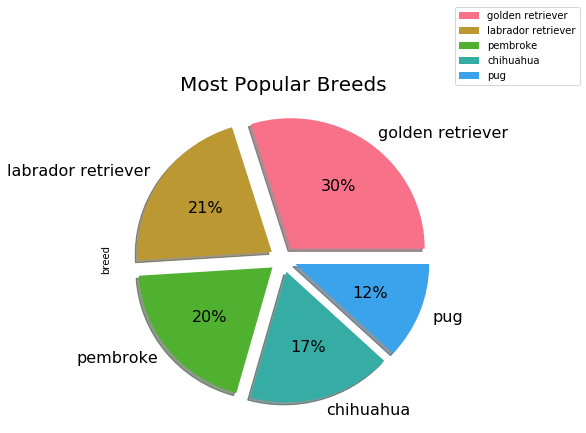

In [83]:
# pie chart showing the most popular breeds
colors = sb.color_palette('husl')[0:5]

#explode all
explode = (0.1, 0.1, 0.1, 0.1, 0.1)  

#create pie chart
plt.figure(figsize=[6,6])
dog_df.breed.value_counts().nlargest(5).plot(kind="pie", labels=top_dog_df.index, autopct='%.0f%%', 
                                      colors = colors, textprops={'fontsize': 16}, 
                explode=explode, shadow=True) #explodes the chart

plt.title('Most Popular Breeds', fontsize=20)
plt.legend(bbox_to_anchor=(1, 1.02), loc='lower left')
plt.show()

The piechart illustrates that the most popular dog breeds on 'WeRateDogs' were Golden retriever (133 dogs), Labrador retriever (94 dogs), Pembroke (87 dogs), Chihuahua (77 dogs), and Pug (53 dogs). Note that the percentage values are based on the distribution of the top five dog breeds.

#### 2. What are the Least Popular Dog Breeds on WeRateDogs (Bottom 5)?

In [84]:
# extract the bottom five breeds with the lowest value counts
least_dog_df = dog_df.breed.value_counts().nsmallest(5)
least_dog_df

japanese spaniel    1
groenendael         1
entlebucher         1
silky terrier       1
clumber             1
Name: breed, dtype: int64

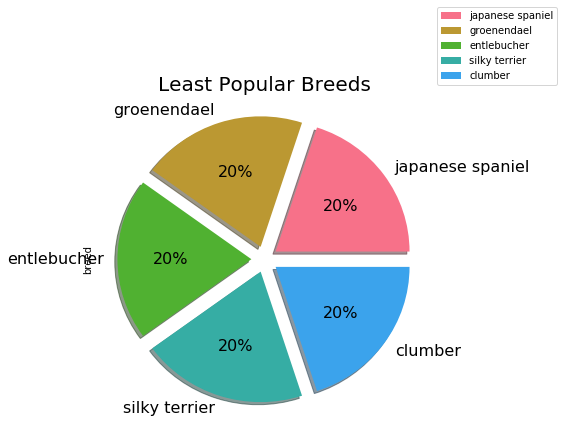

In [85]:
# pie chart showing the least popular breeds
colors = sb.color_palette('husl')[0:5]

# explode all
explode = (0.1, 0.1, 0.1, 0.1, 0.1)  

#create pie chart
plt.figure(figsize=[6,6])
dog_df.breed.value_counts().nsmallest(5).plot(kind="pie", labels=least_dog_df.index, autopct='%.0f%%', 
                                      colors = colors, textprops={'fontsize': 16}, 
                explode=explode, shadow=True) #explodes the chart

plt.title('Least Popular Breeds', fontsize=20)
plt.legend(bbox_to_anchor=(1, 1.02), loc='lower left')
plt.show()

The chart above shows that the least popular dog breeds on 'WeRateDogs' were Silky terrier, Scotch terrier, Japanese spaniel, Clumber and Entlebucher. It is important to note that these might be a random selection from the total least dogs because they all have a value of 1.

#### 3. What are the Top Five Breeds with the highest rating scores on WeRateDogs?

In [86]:
# create a new column, 'rating_score', representing the score for each dog
# rating_score = rating_numerator/rating_denominator

dog_df['rating_score'] = (dog_df['rating_numerator'] / dog_df['rating_denominator'])
dog_df.rating_score.value_counts()

1.200000    375
1.000000    319
1.100000    311
1.300000    206
0.900000    106
0.800000     58
0.700000     24
1.400000     21
0.600000     12
0.500000      9
0.818182      1
0.200000      1
0.220000      1
4.500000      1
Name: rating_score, dtype: int64

In [87]:
# group the original dataframe by breed and extract the mean rating score for the breeds
top_rating_df = dog_df.groupby('breed').agg({'rating_score':'mean'}).reset_index()

# sort the values in desceneding order and select the first five breeds
top_rated_df = top_rating_df.sort_values('rating_score',ascending = False).head(5)

# test
top_rated_df

,breed,rating_score
0,afghan hound,1.300000
85,saluki,1.250000
20,briard,1.233333
99,tibetan mastiff,1.225000
15,border terrier,1.214286


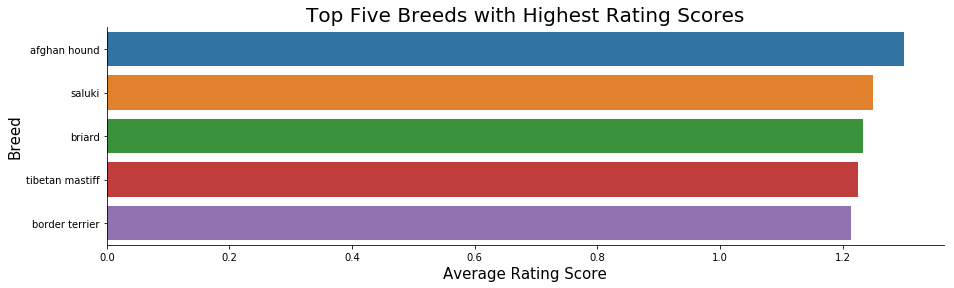

In [88]:
# create a barplot for visualization
fig, ax = plt.subplots(figsize=(15,4))
sb.barplot(data=top_rated_df, x='rating_score', y='breed', ci=None, )

# add titles and labels
plt.title('Top Five Breeds with Highest Rating Scores', fontsize = 20)
plt.xlabel('Average Rating Score', fontsize = 15)
plt.ylabel('Breed', fontsize = 15)

# removing the right and top borders of the axes
sb.despine()

plt.show()

This shows that the dog breeds with the highest rating scores are Afghan hound (1.30), Saluki (1.25), Briard (1.23), Tibetan Mastiff (1.23), and Border Terrier (1.21). It is quite interesting that the most popular dog breeds are not amongst the top five breeds with the highest rating scores.

#### 4. What are the Top Five Breeds with the lowest rating scores on WeRateDogs?

In [89]:
# group the original dataframe by breed and extract the mean rating score for the breeds
least_rating_df = dog_df.groupby('breed').agg({'rating_score':'mean'}).reset_index()

# sort the values in ascending order and select the first five breeds
least_rated_df = least_rating_df.sort_values('rating_score',ascending = True).head(5)

# check
least_rated_df

,breed,rating_score
55,japanese spaniel,0.5
50,ibizan hound,0.9
31,curly-coated retriever,0.9
74,norwich terrier,0.9
104,walker hound,0.9


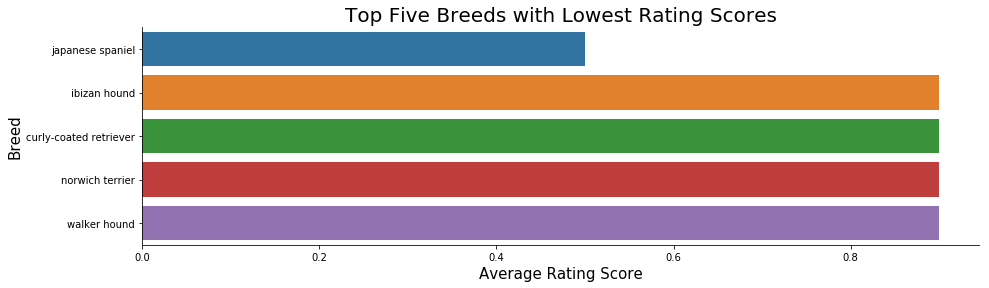

In [90]:
# create a barplot for visualization
fig, ax = plt.subplots(figsize=(15,4))
sb.barplot(data=least_rated_df, x='rating_score', y='breed', ci=None, )

# add titles and labels
plt.title('Top Five Breeds with Lowest Rating Scores', fontsize = 20)
plt.xlabel('Average Rating Score', fontsize = 15)
plt.ylabel('Breed', fontsize = 15)

# removing the right and top borders of the axes
sb.despine()

plt.show()

The plot clearly represents the breeds with the lowest rating scores as Japanese Spaniel (0.5), Ibizan Hound (0.9), Curly-coated Retriever (0.9), Norwich Terrier (0.9), and Walker Hound (0.9).

#### 5. Is there any correlation between favorite_count, retweet_count and rating_score?

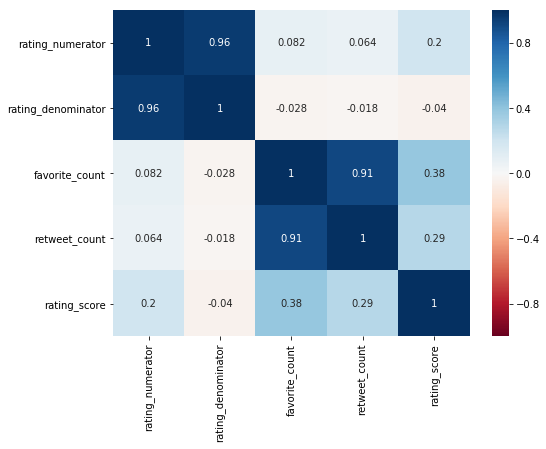

In [91]:
# visualize the relationship between favorite_count, retweet_count and rating_score using a heatmap
color = plt.get_cmap('RdBu')
color.set_bad('grey') 
plt.figure(figsize=[8,6])

corr = dog_df.corr()
sb.heatmap(corr, vmin=-1, vmax=1, annot=True, cmap=color);

There is a strong positive correlation between the favorite counts and retweet counts (r=0.91). This could imply that retweet counts increase as favorite counts increase, but this does not indicate a causal effect. There is also a weak positive correlation between the rating scores and the retweet counts (r=0.29), which implies that rating scores increase as retweet counts increase. Finally, there is a moderate positive correlation between the rating scores and the favorite counts (r=0.38), implting that rating scores increase as favorite counts increase. As earlier stated, correlation does not translate to causation. Causation can be only be ascertained by regression. Therefore, I will like to ascertain if favorite count has an effect on rating score in the next question.

#### 6. Does favorite count have an effect on rating scores?

In [92]:
# perform a linear regression between favorite count and rating score 
import statsmodels.api as sm

X = dog_df['favorite_count']
y = dog_df['rating_score']

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


                            OLS Regression Results                            
Dep. Variable:           rating_score   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     249.9
Date:                Mon, 07 Nov 2022   Prob (F-statistic):           4.79e-52
Time:                        23:21:11   Log-Likelihood:                 498.10
No. Observations:                1445   AIC:                            -992.2
Df Residuals:                    1443   BIC:                            -981.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.0438      0.006    186.

The p value (P>|t|) for favorite_count is 0.00 (p<0.05). This implies that favorite count has a significant effect on rating score. However, the effect size is zero (coef = 0.000005649).

The heatmap showed that there is a strong positive linear correlation between favorite count and retweet count. Additionally, retweet count has a weak positive correlation with rating score. These are possible reasons for the multicollinearity warning.

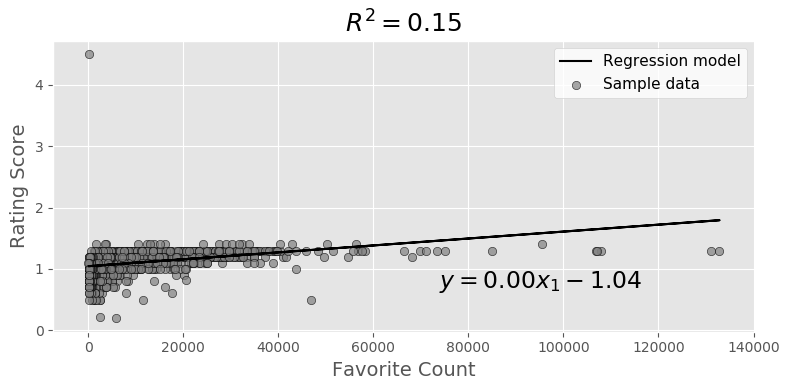

In [93]:
# visualize the regression results
from sklearn import linear_model

# identify the data
x = dog_df['favorite_count'].values.reshape(-1,1)
y = dog_df['rating_score'].values

# create the regression model
ols = linear_model.LinearRegression()
model = ols.fit(x, y)
response = model.predict(x)

# evaluate the r2
r2 = model.score(x, y)

# visualize the regression model

plt.style.use('default')
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(x, response, color='k', label='Regression model')
ax.scatter(x, y, edgecolor='k', facecolor='grey', alpha=0.7, label='Sample data')
ax.set_ylabel('Rating Score', fontsize=14)
ax.set_xlabel('Favorite Count', fontsize=14)
ax.legend(facecolor='white', fontsize=11)
ax.set_title('$R^2= %.2f$' % r2, fontsize=18)
ax.text(0.55, 0.15, '$y = %.2f x_1 - %.2f $' % (model.coef_[0], abs(model.intercept_)),  fontsize=17, transform=ax.transAxes)

fig.tight_layout()

The scatter plot represents the regression output of favorite count and rating score. Favorite count has no effect on rating score (coefficient of x1 = 0.00). This implies that the ratings on WeRateDogs are not determined or affected by the number of favorite counts a dog has earned. However, the validity of this model is only 15% (R2 = 0.15), which implies that the favorite count accounts for only 15% of the variations in rating scores. Therefore, it can be concluded that rating score is more dependent on other factors. One explanation could be that the scores are solely given by the WeRateDogs team.

#### 7. What days have the highest retweet counts and favorite counts?

In [94]:
dog_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1445 entries, 0 to 1643
Data columns (total 10 columns):
tweet_id              1445 non-null object
breed                 1445 non-null object
stage                 218 non-null object
rating_numerator      1445 non-null int64
rating_denominator    1445 non-null int64
favorite_count        1445 non-null int64
retweet_count         1445 non-null int64
date                  1445 non-null datetime64[ns]
time                  1445 non-null object
rating_score          1445 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 124.2+ KB


In [95]:
# extract the day names from the time column
dog_df['day'] = dog_df.date.dt.day_name()

#check
dog_df.head(2)

,tweet_id,breed,stage,rating_numerator,rating_denominator,favorite_count,retweet_count,date,time,rating_score,day
0,892177421306343426,chihuahua,NaN,13,10,33819,6514,2017-08-01,00:17:27,1.3,Tuesday
1,891815181378084864,chihuahua,NaN,12,10,25461,4328,2017-07-31,00:18:03,1.2,Monday


In [96]:
# extract a dataframe from the dog dataframe conatining the mean values of favorite count, retweet count and rating numerator
# group the dataframe by days
day_counts_df = dog_df.groupby('day').agg({'favorite_count':'mean', 'retweet_count':'mean', 
                                           }).reset_index()

# check
day_counts_df

,day,favorite_count,retweet_count
0,Friday,9052.274038,2672.850962
1,Monday,8787.597403,2597.510823
2,Saturday,9828.541436,3239.359116
3,Sunday,8752.558974,2606.179487
4,Thursday,8854.911628,2553.697674
5,Tuesday,9443.229665,2784.602871
6,Wednesday,10604.645631,3175.252427


The output shows that the days with the highest favorite and retweet counts were Saturday and Wednesday. This implies that Saturdays and Wednesdays might be one of the best days to post a dog.

### Insights:
1. The most popular dog breeds in WeRateDogs are Golden retriever, Labrador retriever, Pembroke, Chihuahua, and Pug.

2. The top five breeds with the highest rating scores are Afghan hound, Saluki, Briard, Tibetan mastiff, and Border terrier.

3. There is a strong positive correlation between favorite counts and retweet counts (r=0.91). There is a weak positive correlation between rating scores and retweet counts (r=0.29), and between rating scores and favorite counts (r=0.38).

4. However, favorite count does not affect rating scores on WeRateDogs.

5. Saturdays and Wednesdays are good days to post a dog.

## Conclusion

This project wrangled, analzed, and documented insights from the 'WeRateDogs' data. The following conclusions can be made from the analysis: the most popular dogbreeds were not amongst the top breeds with the highest rating scores. Aditionally, the favorite counts does not have an effect on, and accounts for only 15% of the variation in rating scores. This buttressed the fact that the dogs are scored by the WeRateDogs team. Finally, Saturdays and Wednesdays are good days to post a dog with respect to retweet and favorite counts.